# DSA5103 Homework3
## Zhang Youyang

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import svd, norm
import scipy.sparse as sps
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import time
import os

### Part a

In [2]:
m = 500
n = 1000
W = np.random.rand(m, 10)
H = np.random.rand(10, n)
L0 = np.dot(W, H)
S0 = sps.random(m, n, density=0.05)
M = L0 + S0

lambd = 1 / np.sqrt(max(m,n))

In [3]:
def prox_nuclear_norm_full(M, tau):
    m,n = M.shape
    U, s, V = svd(M, full_matrices=True)
    s_thresh = soft_threshold(s, tau)
    if m < n:
        return U @ np.diag(s_thresh) @ V[:m, :]
    else:
        return U[:, :n] @ np.diag(s_thresh) @ V
    

def soft_threshold(M, tau):
    return np.multiply(np.maximum(np.abs(M) - tau, 0), np.sign(M))

def admm_rpca(X, lambd, L0, S0, basketball=False, sigma=1, max_iter=200, tol=1e-4):
    m, n = X.shape
    # initialize 
    if basketball:
        L = L0
        S = S0
    else:
        L = np.zeros((m, n))
        S = np.zeros((m, n))
    Z = np.zeros((m, n))
    
    t_start = time.time()
    for i in range(max_iter):
        L_prev = L.copy()
        S_prev = S.copy()
        
        # update L, S, and Z
        L = prox_nuclear_norm_full(X - S + (1/sigma) * Z, 1/sigma)
        S = soft_threshold(X - L + (1/sigma) * Z, lambd/sigma)
        Z = Z + sigma * (X - L - S)

        # calculate r
        rL = norm(L - L_prev, 'fro') / (1 + norm(L, 'fro'))
        rS = norm(S - S_prev, 'fro') / (1 + norm(S, 'fro'))
        r = max(rL, rS)

        if r < tol:
            break

    t_end = time.time()
    runtime = t_end - t_start
    num_iters = i + 1
    print('The final r: ', r)
    
    return L, S, num_iters, runtime


In [4]:
L, S, num_iters, runtime = admm_rpca(M, lambd, L0, S0)
L_L0 = norm(L - L0)
S_S0 = norm(S - S0)
print('Different between L and L0: ', L_L0)
print('Difference between S and S0: ', S_S0)
print('num of iterations: ', num_iters)
print('running time in seconds: ', runtime)

The final r:  6.473820542145829e-05
Different between L and L0:  0.004000915515971319
Difference between S and S0:  0.01822026355829002
num of iterations:  16
running time in seconds:  8.448824882507324


### Part b

In [5]:
def prox_nuclear_norm_reduced(M, tau):
    U, s, V = svd(M, full_matrices=False)
    s_thresh = soft_threshold(s, tau)
    return U @ np.diag(s_thresh) @ V

def admm_rpca_quick(X, lambd, L0, S0, rho=1.1, basketball=False, max_iter=200, tol=1e-4):
    m, n = X.shape
    # initialize 
    if basketball:
        L = L0
        S = S0
    else:
        L = np.zeros((m, n))
        S = np.zeros((m, n))
    Z = np.zeros((m, n))
    sigma = 1 / svd(X, compute_uv=False)[0]
    
    t_start = time.time()
    for i in range(max_iter):
        L_prev = L.copy()
        S_prev = S.copy()
        
        # update sigma, L, S, and Z
        sigma = rho * sigma
        L = prox_nuclear_norm_reduced(X - S + (1/sigma) * Z, 1/sigma)
        S = soft_threshold(X - L + (1/sigma) * Z, lambd/sigma)
        Z = Z + sigma * (X - L - S)

        # calculate r
        rL = norm(L - L_prev, 'fro') / (1 + norm(L, 'fro'))
        rS = norm(S - S_prev, 'fro') / (1 + norm(S, 'fro'))
        r = max(rL, rS)

        if r < tol:
            break

    t_end = time.time()
    runtime = t_end - t_start
    num_iters = i + 1
    print('The final r: ', r)
    
    return L, S, num_iters, runtime

In [6]:
L2, S2, num_iters2, runtime2 = admm_rpca_quick(M, lambd, L0, S0)
L2_L0 = norm(L2 - L0)
S2_S0 = norm(S2 - S0)
print('Different between L and L0: ', L2_L0)
print('Difference between S and S0: ', S2_S0)
print('num of iterations: ', num_iters2)
print('running time in seconds: ', runtime2)

The final r:  3.676410149379394e-15
Different between L and L0:  176.9637188879973
Difference between S and S0:  91.61467879211239
num of iterations:  3
running time in seconds:  1.4164628982543945


### Part c

In [7]:
# import csv
df = pd.read_csv('BasketballPlayer.csv', header=None)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,0.223830,0.204292,0.189163,0.184745,0.194036,0.227759,0.162771,0.215826,0.133437,0.186858,...,0.160639,0.206081,0.135273,0.145987,0.122019,0.159719,0.196899,0.171275,0.167112,0.182210
1,0.210351,0.193268,0.183860,0.175863,0.220272,0.180747,0.169331,0.203538,0.158989,0.184934,...,0.180608,0.132878,0.166129,0.196189,0.154891,0.184666,0.176955,0.191614,0.206116,0.163760
2,0.178248,0.184763,0.201847,0.186458,0.183437,0.152568,0.156086,0.188946,0.199349,0.153144,...,0.153838,0.149928,0.131516,0.159828,0.177870,0.216114,0.171060,0.176999,0.183410,0.172360
3,0.180761,0.200290,0.210865,0.191112,0.183437,0.185996,0.157399,0.188946,0.208974,0.147272,...,0.173453,0.167700,0.129214,0.176959,0.174653,0.224015,0.163919,0.176999,0.181548,0.173607
4,0.166436,0.194364,0.196739,0.191610,0.202936,0.192123,0.158841,0.169898,0.171682,0.213292,...,0.172784,0.147554,0.157831,0.166407,0.142739,0.144139,0.138830,0.183289,0.180580,0.157827


In [9]:
len(df)

1261332

In [10]:
# initialize L0 and S0
M = df.values
m,n = M.shape
W = np.random.rand(m, 10)
H = np.random.rand(10, n)
L0 = np.dot(W, H)
S0 = sps.random(m, n, density=0.05)

lambd = 1 / np.sqrt(max(m,n))

In [11]:
# Apply improved algorithm from part b to do background-foreground segmentation
back_L, fore_S, num_iters0, runtime0 = admm_rpca_quick(M, lambd, L0, S0, basketball=True)
print('num of iterations: ', num_iters0)
print('running time in seconds: ', runtime0)
print('Rank of estimated L: ', np.linalg.matrix_rank(back_L))
print('Number of nonzero entries in S: ', np.count_nonzero(fore_S))

The final r:  8.562307245149872e-05
num of iterations:  81
running time in seconds:  1742.190316915512
Rank of estimated L:  45
Number of nonzero entries in S:  133225978


### Part d

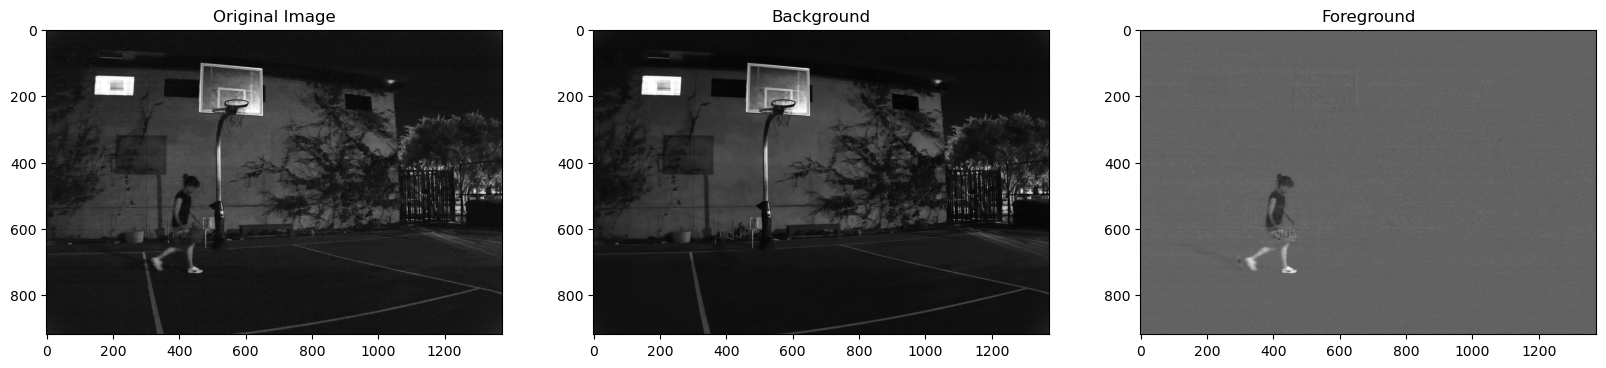

In [141]:
def rescaler(x):
    return (x - np.min(x))/ (np.max(x) - np.min(x))

# Visualize 20th frame
frame20 = df[19].values.reshape((918, 1374), order='F')
background = back_L[:, 19].reshape((918, 1374), order='F')
foreground = fore_S[:, 19].reshape((918, 1374), order='F')
original = rescaler(frame20)
background_L = rescaler(background)
object_S = rescaler(foreground)

f, axarr = plt.subplots(1,3, figsize=(20, 60))
axarr[0].set_title('Original Image')
axarr[0].imshow(original, cmap='gray')
axarr[1].set_title('Background')
axarr[1].imshow(background_L, cmap='gray')
axarr[2].set_title('Foreground')
axarr[2].imshow(object_S, cmap='gray')
plt.show()

### Part e

In [142]:
def write_video(file_name, frames):
    # Create a video writer object
    fps = 25.0
    frame_size = (1374, 918)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(file_name, fourcc, \
                          fps, frame_size, isColor=False)

    # Loop through the frames and write them to the output video
    for frame_idx in range(frames.shape[1]):
        # Convert the frame array to an image
        frame = frames[:, frame_idx].reshape((918,1374), order='F')
        frame = rescaler(frame)
        frame = (frame * 255).astype(np.uint8)
        
        # Write the image to the output video
        out.write(frame)

    # Release the video writer object and close the output file
    out.release()

In [145]:
# create a video for background
file_name = 'background_L.mp4'
write_video(file_name, back_L)

In [146]:
# create a video for foreground
file_name = 'foreground_S.mp4'
write_video(file_name, fore_S)